In [2]:
import pandas as pd
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
mlflow.__version__

'3.5.1'

In [41]:
# Load all mlflow experiments and run data
experiments = mlflow.search_experiments()

In [42]:
# Extract runs from a specific experiment
# experiments[0].experiment_id

experiment_id = '870565023039204259'
runs = mlflow.search_runs(experiment_ids=[experiment_id])


In [46]:
import mlflow

# --- You need the ID of the run you want to load from ---
run_id = "YOUR_RUN_ID"  # Example: "a1b2c3d4e5f6"

# This is the filename you used in log_dict()
RUN_ID = runs[runs["tags.mlflow.runName"]=="serious-sloth-51"].run_id.iloc[0]
artifact_filename = "personalized_weight_matrix.npy" 

# 1. Construct the artifact URI
#    This format "runs:/<run_id>/<path_to_artifact>"
artifact_uri = f"mlruns/{RUN_ID}/artifacts/models/{artifact_filename}"

# 2. Load the dictionary directly
try:
    loaded_data = mlflow.artifacts.load_dict(artifact_uri)
    
    print("Successfully loaded dictionary:")
    print(loaded_data)

except Exception as e:
    print(f"Failed to load artifact: {e}")

Failed to load artifact: The following failures occurred while downloading one or more artifacts from mlruns/5e72bc0a5c044925a0ba6bcf7c0fc6e9/artifacts/models:
##### File personalized_weight_matrix.npy #####
[Errno 2] No such file or directory: 'mlruns\\5e72bc0a5c044925a0ba6bcf7c0fc6e9\\artifacts\\models\\personalized_weight_matrix.npy'


## Accuracy v accuracy

In [11]:
RUN_ID = runs[runs["tags.mlflow.runName"]=="painted-turtle-210"].run_id.iloc[0]
client = mlflow.MlflowClient()
run = client.get_run(RUN_ID)

metrics_history = {}
for metric in run.data.metrics.keys():
    metric_history = client.get_metric_history(run_id=RUN_ID, key=metric)
    metrics_history[metric] = [metric_history.value for metric_history in metric_history]
metrics_history_df = pd.DataFrame(metrics_history)
metrics_history_df['epoch'] = metrics_history_df.index + 1

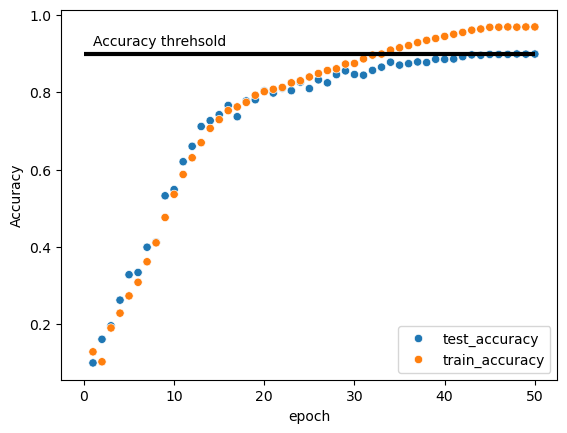

In [12]:
short_metrics_history_df = metrics_history_df.melt(id_vars=['epoch'], var_name='metric', value_name='value')
g = sns.scatterplot(data=short_metrics_history_df[short_metrics_history_df.metric.str.contains('accuracy')], x='epoch', y='value', hue='metric')
plt.hlines(xmin=0, xmax=short_metrics_history_df.epoch.max(), y=0.9, color='black', linewidth=3)
g.set_ylabel('Accuracy')
g.text(1, 0.92, 'Accuracy threhsold', color='black')
g.legend(loc='lower right')

## Accuracy v cost-based accuracy

In [49]:
run_names = ['serious-sloth-51', 'masked-hawk-571', 'indecisive-finch-168', 'intelligent-hawk-589']
# RUN_ID = runs[runs["tags.mlflow.runName"]=="indecisive-finch-168"].run_id.iloc[0]
RUN_ID = runs[runs["tags.mlflow.runName"]==run_names[0]].run_id.iloc[0]

client = mlflow.MlflowClient()
run = client.get_run(RUN_ID)

metrics_history = {}
for metric in run.data.metrics.keys():
    metric_history = client.get_metric_history(run_id=RUN_ID, key=metric)
    metrics_history[metric] = [metric_history.value for metric_history in metric_history]
metrics_history_df = pd.DataFrame(metrics_history)
metrics_history_df['epoch'] = metrics_history_df.index + 1

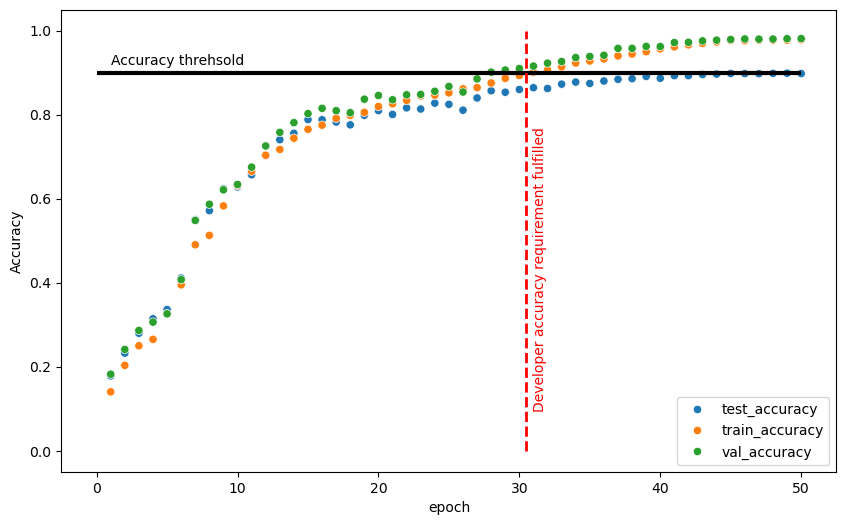

In [50]:
short_metrics_history_df = metrics_history_df.melt(id_vars=['epoch'], var_name='metric', value_name='value')
accuracy_only = ['train_accuracy', 'val_accuracy', 'test_accuracy']
fig, ax = plt.subplots(figsize=(10, 6))
g = sns.scatterplot(data=short_metrics_history_df[short_metrics_history_df.metric.isin(accuracy_only)], x='epoch', y='value', hue='metric', ax=ax)
plt.hlines(xmin=0, xmax=short_metrics_history_df.epoch.max(), y=0.9, color='black', linewidth=3)
plt.vlines(x=30.5, ymin=0, ymax=1, color='red', linestyle='--', linewidth=2)
g.set_ylabel('Accuracy')
g.text(1, 0.92, 'Accuracy threhsold', color='black')
g.text(31, 0.1, 'Developer accuracy requirement fulfilled', color='red', rotation=90)
g.legend(loc='lower right')

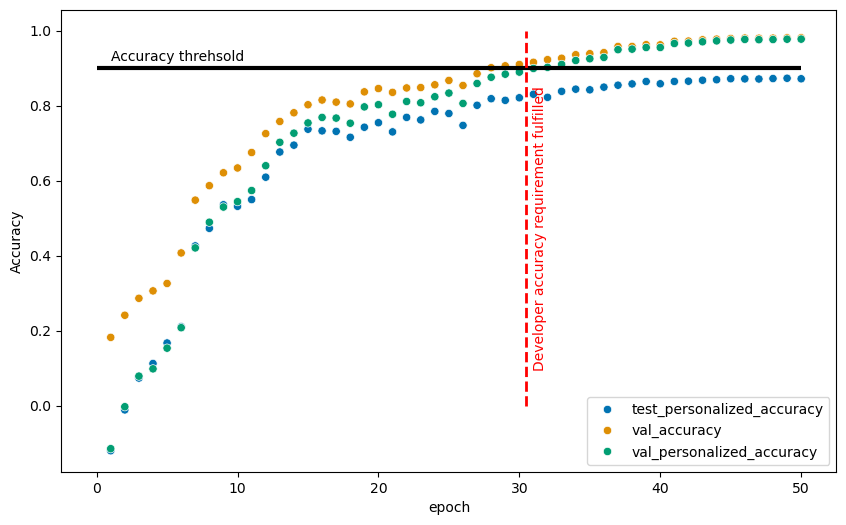

In [51]:
short_metrics_history_df = metrics_history_df.melt(id_vars=['epoch'], var_name='metric', value_name='value')
metrics = ['val_accuracy', 'val_personalized_accuracy', 'test_personalized_accuracy']
fig, ax = plt.subplots(figsize=(10, 6))
g = sns.scatterplot(data=short_metrics_history_df[short_metrics_history_df.metric.isin(metrics)], x='epoch', y='value', hue='metric', ax=ax, palette='colorblind')
plt.hlines(xmin=0, xmax=short_metrics_history_df.epoch.max(), y=0.9, color='black', linewidth=3)
plt.vlines(x=30.5, ymin=0, ymax=1, color='red', linestyle='--', linewidth=2)



g.set_ylabel('Accuracy')
g.text(1, 0.92, 'Accuracy threhsold', color='black')
g.text(31, 0.1, 'Developer accuracy requirement fulfilled', color='red', rotation=90)
g.legend(loc='lower right')

# Loading model

In [8]:
# Load state dict from artifacts of the mlflow run
import torch 
import models
model_state_dict_path = f"mlruns/{RUN_ID}/artifacts/models/state-dict.pth"
architecture_name = 'VGG19'
architecture = getattr(models, architecture_name)
model = architecture.base()

model_state_dict = torch.load(model_state_dict_path)
model.load_state_dict(model_state_dict)
model.eval()
loaded_model = mlflow.pytorch.load_model(f"mlruns/{RUN_ID}/artifacts/models")


OSError: [WinError 182] The operating system cannot run %1. Error loading "c:\Users\P70088982\AppData\Local\miniconda3\envs\new-dnn-mode-connectivity\lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.